In [1]:
# Import necessary libraries
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import json
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Task 1: Base ResNet Evaluation
# =============================

# Define preprocessing transformations
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

# Create transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])


In [3]:
import zipfile
import os

# Unzip the dataset
with zipfile.ZipFile("/content/TestDataSet.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/TestDataSet")


In [4]:
# Load dataset
dataset_path = "/content/TestDataSet/TestDataSet"
labels_json_path = "/content/TestDataSet/TestDataSet/labels_list.json"

# Load ImageNet dataset with transformations
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

In [5]:
# Create index to folder name mapping
index_to_folder = {v: k for k, v in dataset.class_to_idx.items()}

# Load labels and create folder to ImageNet ID mapping
with open(labels_json_path) as f:
    label_lines = json.load(f)

imagenet_indices = [int(line.split(":")[0]) for line in label_lines]
folder_to_imagenet_id = {
    index_to_folder[i]: imagenet_indices[i]
    for i in range(len(imagenet_indices))
}

# Load pre-trained ResNet-34 model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.eval().to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 171MB/s]


In [6]:
def evaluate_model(model, dataloader, index_to_folder, folder_to_imagenet_id):
    model.eval()
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = F.cross_entropy(outputs, labels)
            losses.append(loss.item())

            _, top5_predicted = outputs.topk(5, 1, True, True)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                folder_name = index_to_folder.get(labels[i].item())
                if folder_name is None:
                    continue

                true_class_idx = folder_to_imagenet_id.get(folder_name)
                if true_class_idx is None:
                    continue

                pred_list = top5_predicted[i].tolist()
                if pred_list[0] == true_class_idx:
                    correct_top1 += 1
                if true_class_idx in pred_list:
                    correct_top5 += 1

                total += 1

    top1_accuracy = correct_top1 / total * 100 if total > 0 else 0
    top5_accuracy = correct_top5 / total * 100 if total > 0 else 0

    # Plot: Evaluation loss curve
    fig_loss = plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Batch Loss')
    plt.title('Evaluation Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

    return {
        'top1_accuracy': top1_accuracy,
        'top5_accuracy': top5_accuracy,
        'loss_curve': fig_loss
    }


Base Model - Top-1 Accuracy: 70.40%
Base Model - Top-5 Accuracy: 93.20%
Evaluation Loss Curve:


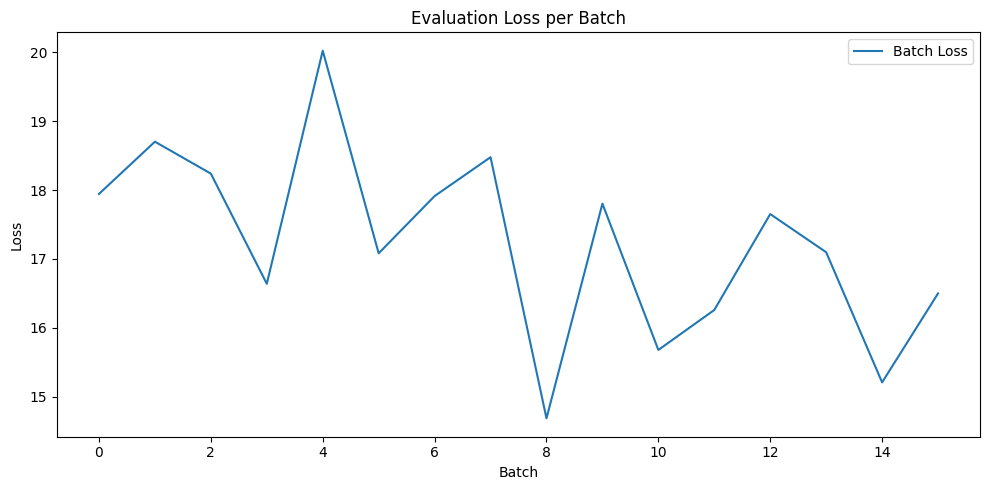

In [7]:
# Evaluate base model
base_results = evaluate_model(pretrained_model, dataloader, index_to_folder, folder_to_imagenet_id)

# Print results
print(f"Base Model - Top-1 Accuracy: {base_results['top1_accuracy']:.2f}%")
print(f"Base Model - Top-5 Accuracy: {base_results['top5_accuracy']:.2f}%")

# Show loss curve
print("Evaluation Loss Curve:")
base_results['loss_curve'].show()


In [8]:
# Task 2: FGSM Attack
# ===================

def fgsm_attack(image, label, model, epsilon):
    """
    Perform FGSM attack on a single image

    Args:
        image: Input image tensor
        label: True label
        model: Model to attack
        epsilon: Attack budget

    Returns:
        Perturbed image
    """
    image.requires_grad = True

    # Forward pass
    output = model(image)
    loss = F.cross_entropy(output, label)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Get gradient of loss w.r.t. image
    data_grad = image.grad.data

    # Generate perturbed image
    perturbed_image = image + epsilon * data_grad.sign()

    # Clip to maintain valid pixel range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image.detach()


In [11]:
# Generate adversarial examples
# FGSM adversarial example generation
epsilon = 0.02
adv_images = []
adv_labels = []

# Generate FGSM adversarial examples
for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)
        adv_img = fgsm_attack(img, label, pretrained_model, epsilon)
        adv_images.append(adv_img.cpu())
        adv_labels.append(label.cpu())  # Still shape: [1]

# ✅ FIX: Convert list of tensors into shape-compatible tensors
adv_images_tensor = torch.cat(adv_images, dim=0)
adv_labels_tensor = torch.cat(adv_labels, dim=0).view(-1)  # Ensure 1D shape

# Save as TensorDataset
from torch.utils.data import TensorDataset, DataLoader

adv_dataset = TensorDataset(adv_images_tensor, adv_labels_tensor)
torch.save(adv_dataset, "AdversarialTestSet1.pt")
print("AdversarialTestSet1.pt saved successfully.")



AdversarialTestSet1.pt saved successfully.


FGSM Attack - Top-1 Accuracy: 39.00%
FGSM Attack - Top-5 Accuracy: 60.60%


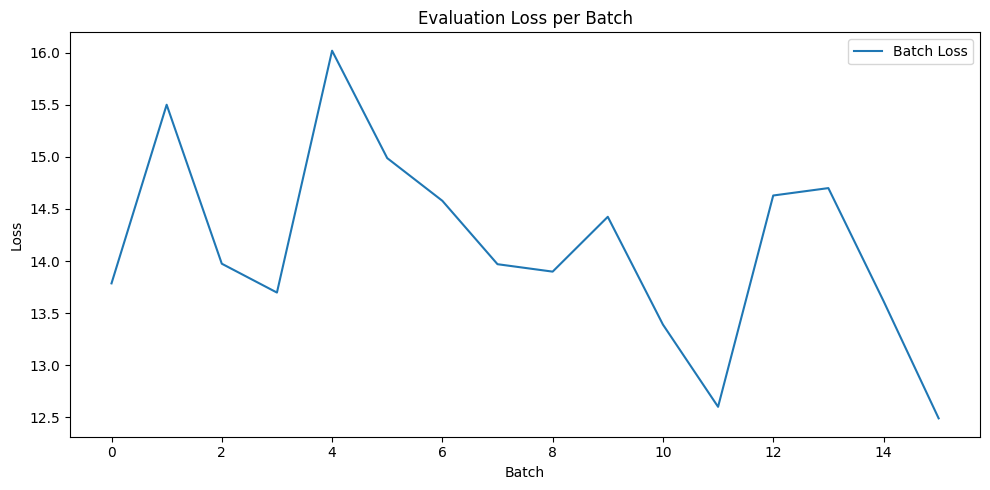

In [12]:
# Create adversarial dataset
adv_images_tensor = torch.cat(adv_images)
adv_labels_tensor = torch.cat(adv_labels)
adv_dataset = TensorDataset(adv_images_tensor, adv_labels_tensor)
torch.save(adv_dataset, "AdversarialTestSet1.pt")

# Evaluate on adversarial examples
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)
fgsm_results = evaluate_model(pretrained_model, adv_loader, index_to_folder, folder_to_imagenet_id)
print(f"FGSM Attack - Top-1 Accuracy: {fgsm_results['top1_accuracy']:.2f}%")
print(f"FGSM Attack - Top-5 Accuracy: {fgsm_results['top5_accuracy']:.2f}%")

In [13]:
# Visualize some adversarial examples
def unnormalize(t):
    """Reverse ImageNet normalization for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (t * std + mean).clamp(0, 1)


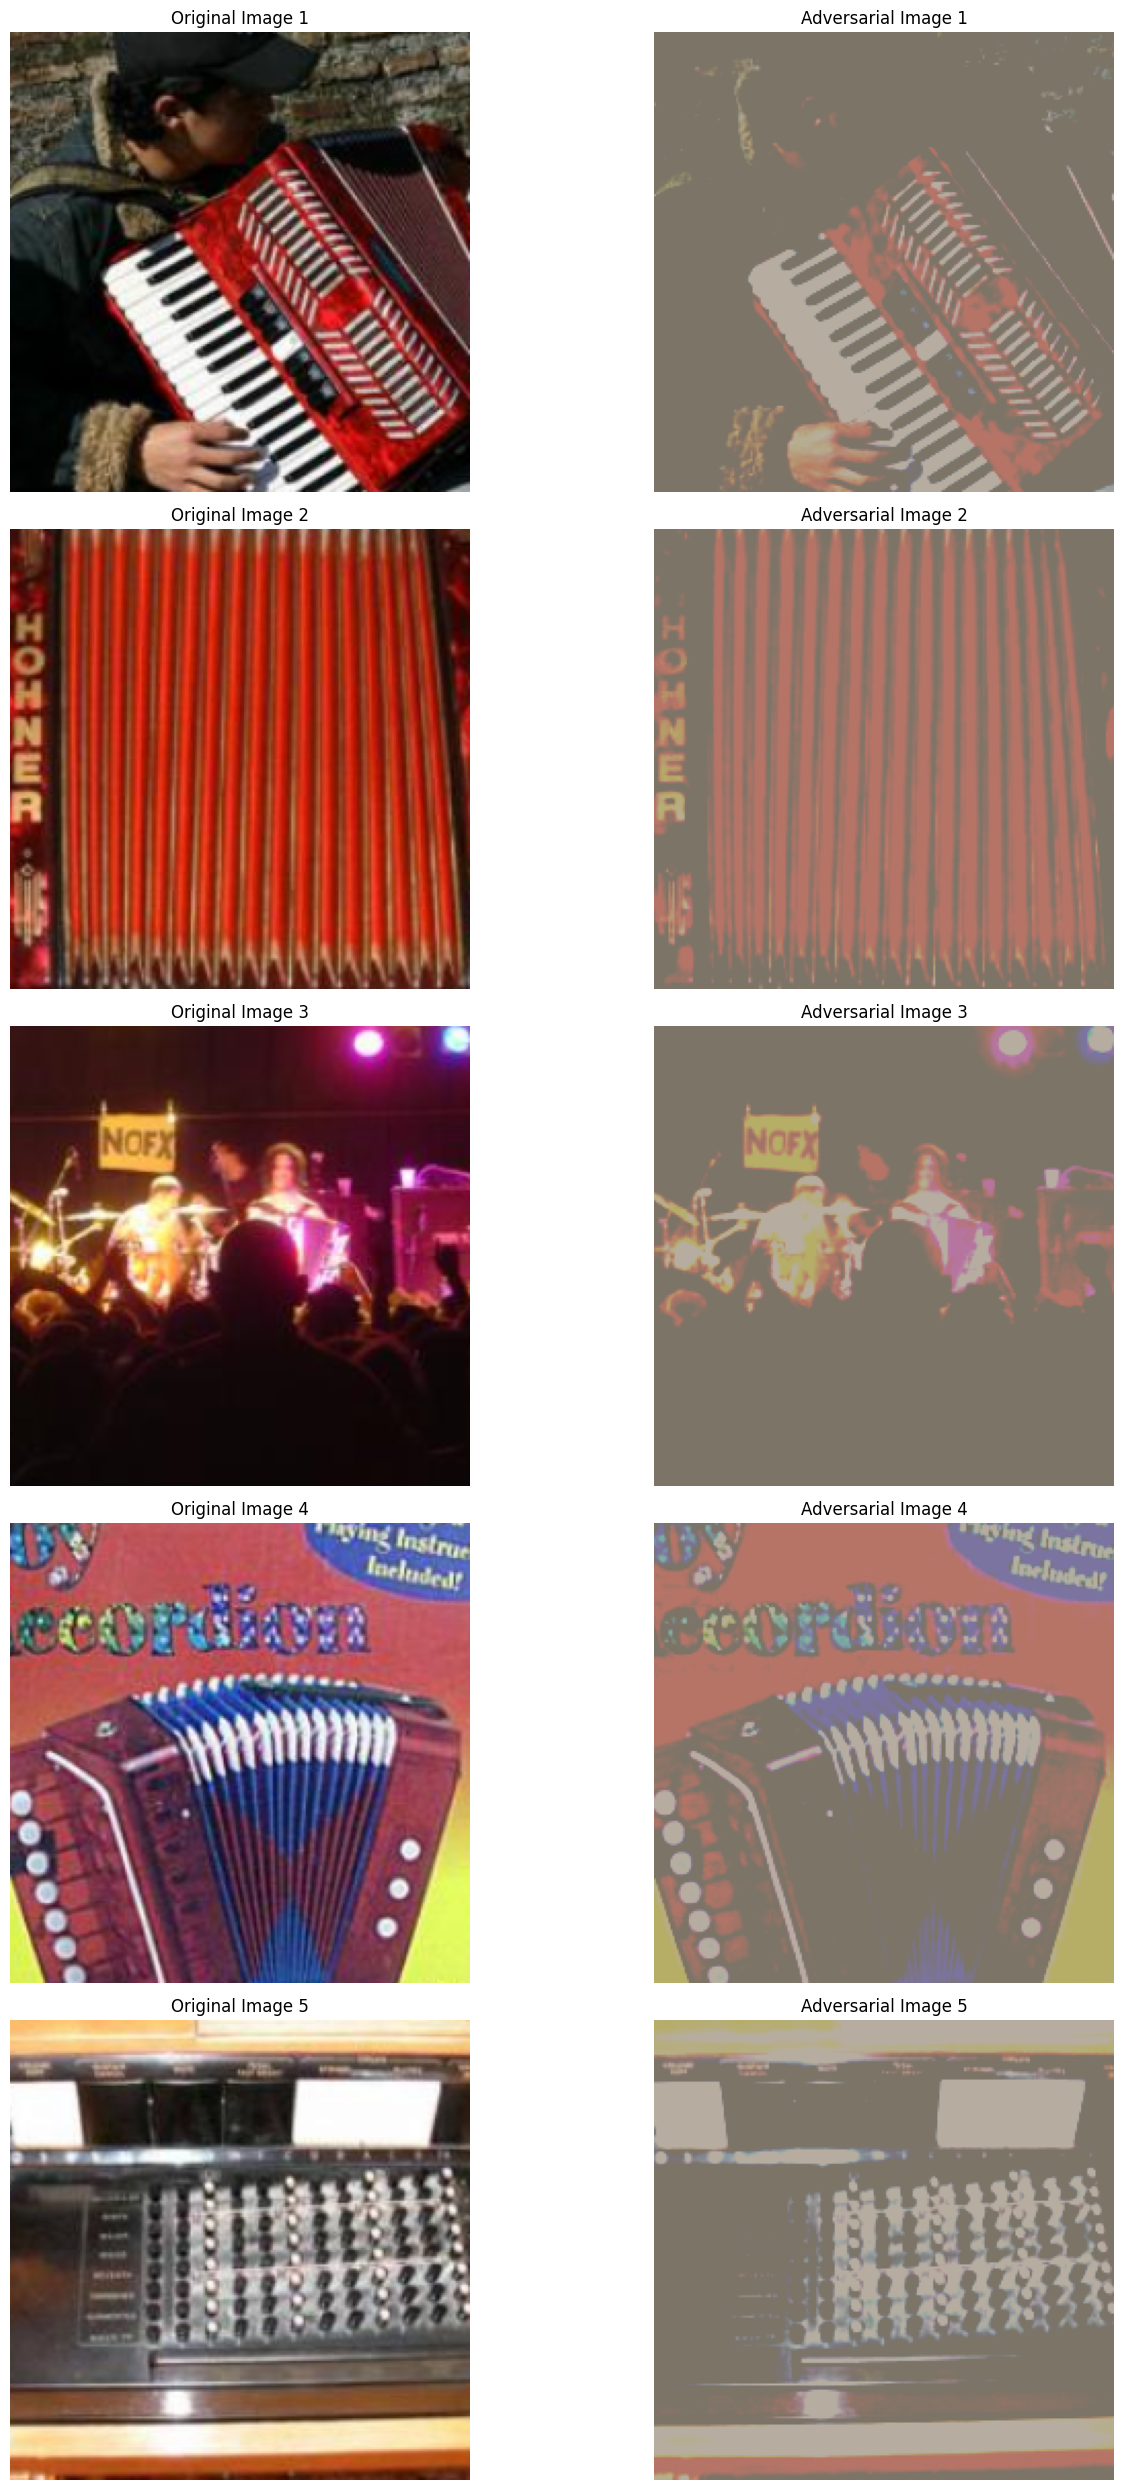

In [14]:
# Plot original vs adversarial examples
num_examples = 5
plt.figure(figsize=(15, 5 * num_examples))
for i in range(num_examples):
    # Original image
    orig_img = unnormalize(dataset[i][0])

    # Adversarial image
    adv_img = unnormalize(adv_images_tensor[i])

    # Plot
    plt.subplot(num_examples, 2, 2*i+1)
    plt.imshow(orig_img.permute(1, 2, 0).numpy())
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    plt.subplot(num_examples, 2, 2*i+2)
    plt.imshow(adv_img.permute(1, 2, 0).numpy())
    plt.title(f"Adversarial Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Task 3: Iterative FGSM Attack
# =============================

def iterative_fgsm(image, label, model, epsilon=0.02, alpha=0.005, steps=10):
    """
    Perform iterative FGSM attack

    Args:
        image: Input image tensor
        label: True label
        model: Model to attack
        epsilon: Total attack budget
        alpha: Step size per iteration
        steps: Number of iterations

    Returns:
        Perturbed image
    """
    original_image = image.clone().detach()
    adv_image = image.clone().detach().requires_grad_(True)

    for _ in range(steps):
        output = model(adv_image)
        loss = F.cross_entropy(output, label)

        model.zero_grad()
        loss.backward()

        # Update adversarial image
        adv_image = adv_image + alpha * adv_image.grad.sign()

        # Project back to epsilon-ball and clip to valid range
        perturbation = torch.clamp(adv_image - original_image, min=-epsilon, max=epsilon)
        adv_image = torch.clamp(original_image + perturbation, 0, 1).detach()
        adv_image.requires_grad_()

    return adv_image

Iterative FGSM - Top-1 Accuracy: 38.20%
Iterative FGSM - Top-5 Accuracy: 53.80%


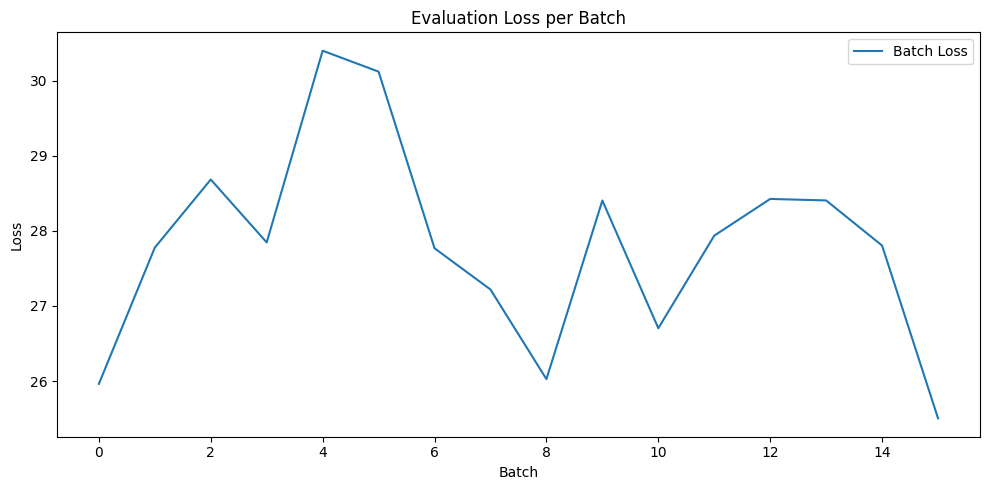

In [16]:
# Generate improved adversarial examples
improved_adv_images = []
improved_adv_labels = []

for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)
        adv_img = iterative_fgsm(img, label, pretrained_model, epsilon=0.02, alpha=0.005, steps=10)
        improved_adv_images.append(adv_img.cpu())
        improved_adv_labels.append(label.cpu())

# Create improved adversarial dataset
improved_adv_images_tensor = torch.cat(improved_adv_images)
improved_adv_labels_tensor = torch.cat(improved_adv_labels)
adv_dataset_2 = TensorDataset(improved_adv_images_tensor, improved_adv_labels_tensor)
torch.save(adv_dataset_2, "AdversarialTestSet2.pt")

# Evaluate improved attack
adv_loader_2 = DataLoader(adv_dataset_2, batch_size=32, shuffle=False)
iterative_results = evaluate_model(pretrained_model, adv_loader_2, index_to_folder, folder_to_imagenet_id)
print(f"Iterative FGSM - Top-1 Accuracy: {iterative_results['top1_accuracy']:.2f}%")
print(f"Iterative FGSM - Top-5 Accuracy: {iterative_results['top5_accuracy']:.2f}%")

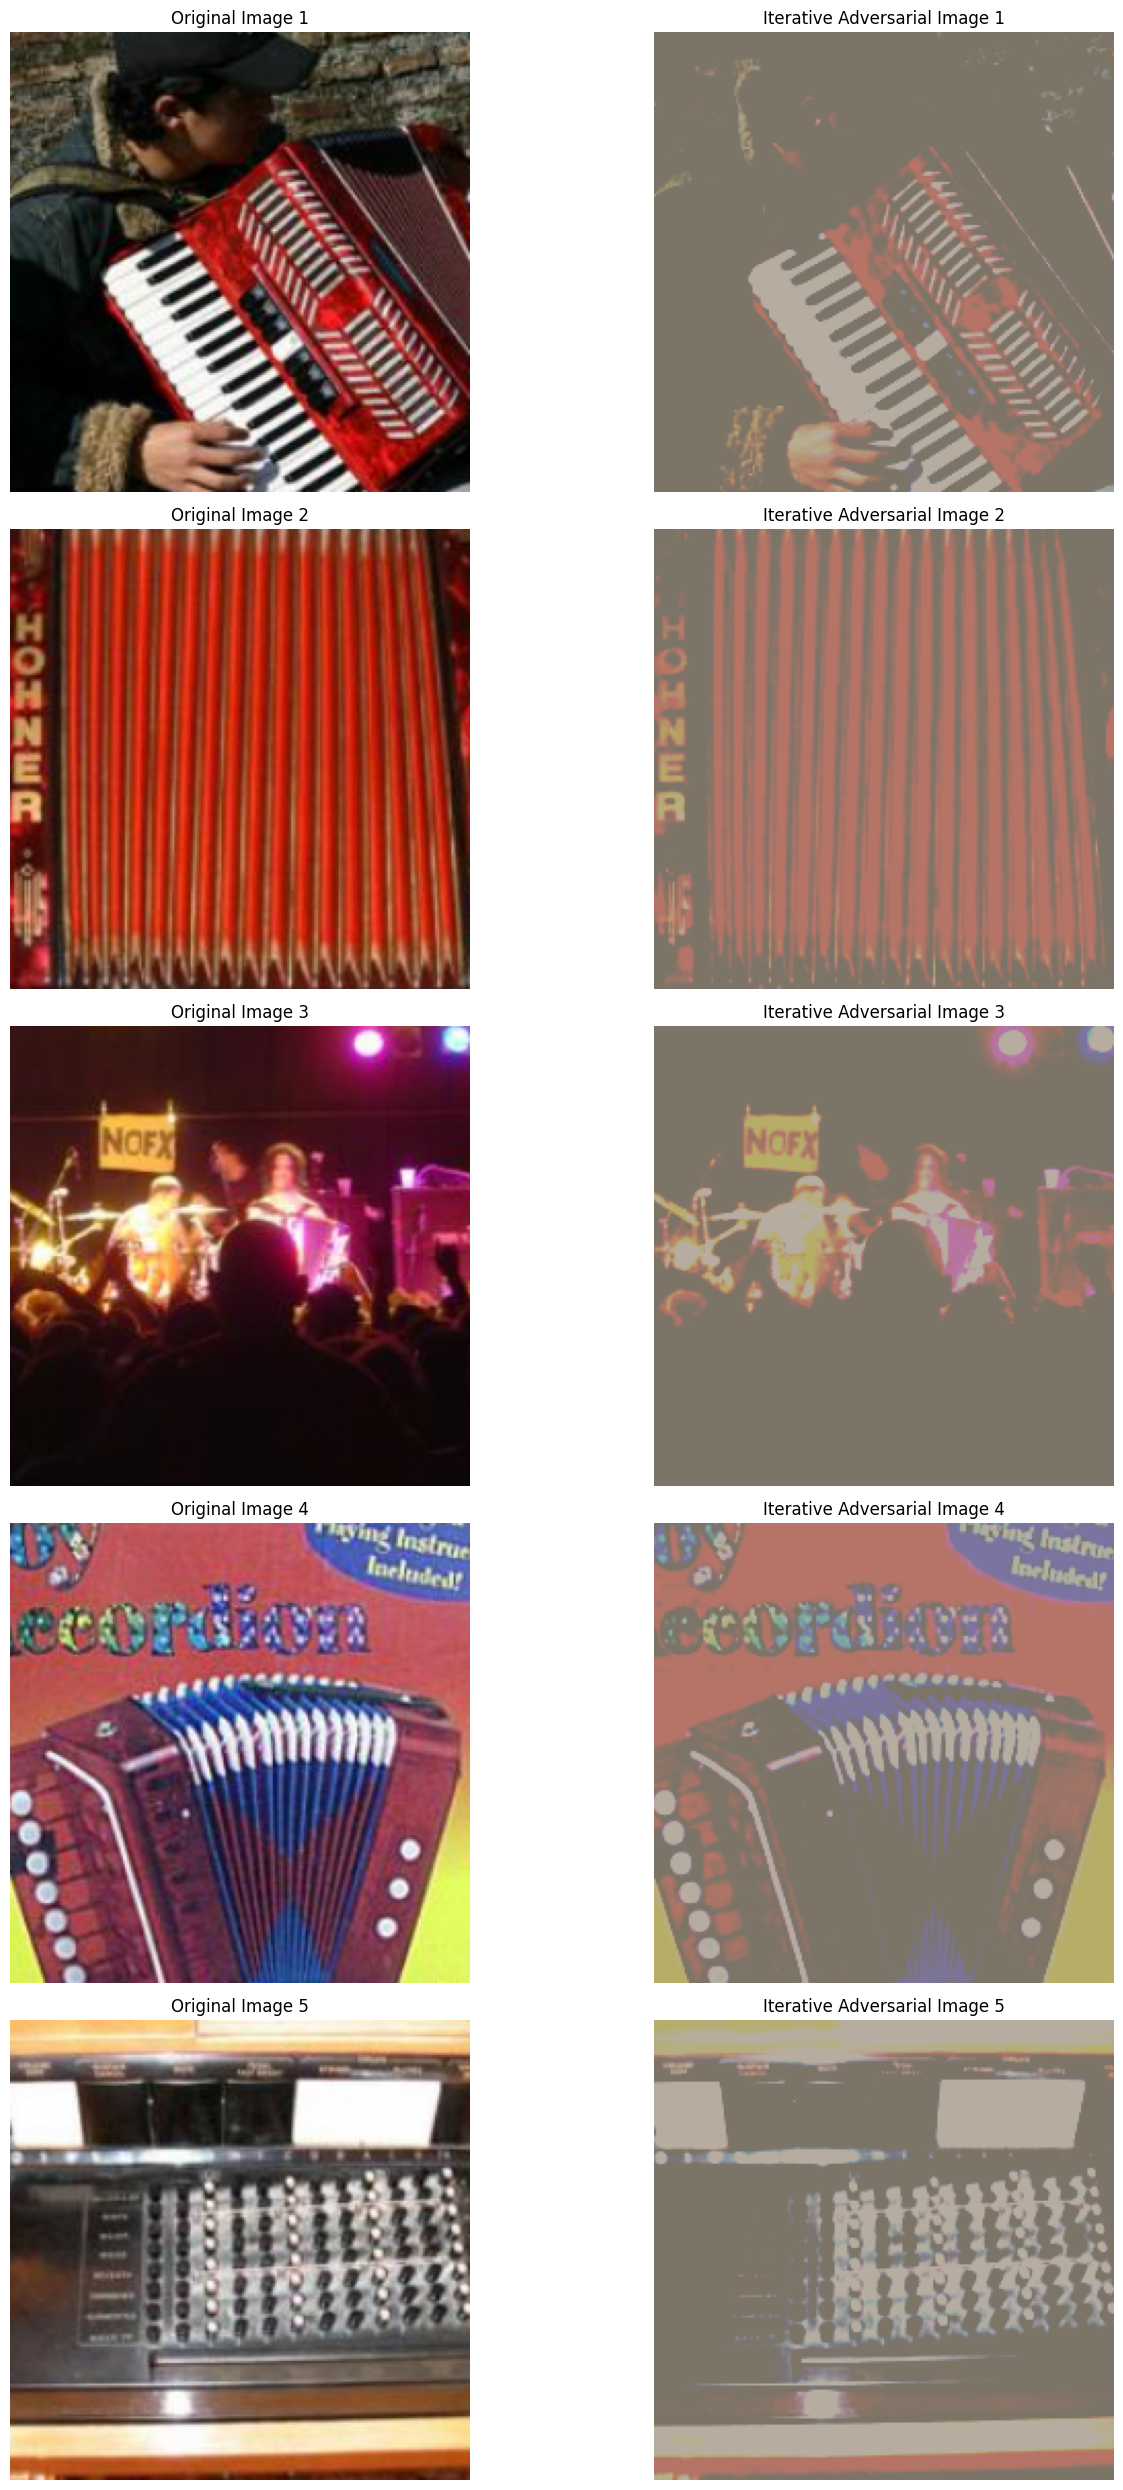

In [18]:
# Visualize improved adversarial examples
plt.figure(figsize=(15, 5 * num_examples))
for i in range(num_examples):
    # Original image
    orig_img = unnormalize(dataset[i][0])

    # Improved adversarial image
    adv_img = unnormalize(improved_adv_images_tensor[i])

    # Plot original
    plt.subplot(num_examples, 2, 2*i+1)
    plt.imshow(orig_img.permute(1, 2, 0).detach().numpy())
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Plot adversarial
    plt.subplot(num_examples, 2, 2*i+2)
    plt.imshow(adv_img.permute(1, 2, 0).detach().numpy())
    plt.title(f"Iterative Adversarial Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
# Task 4: Patch Attack
# ====================

def patch_attack(image, label, model, epsilon=0.3, alpha=0.03, steps=10, patch_size=32, x=None, y=None):
    """
    Perform patch-based adversarial attack

    Args:
        image: Input image tensor
        label: True label
        model: Model to attack
        epsilon: Total attack budget
        alpha: Step size per iteration
        steps: Number of iterations
        patch_size: Size of the adversarial patch
        x, y: Coordinates of patch (if None, random)

    Returns:
        Perturbed image
    """
    image = image.clone().detach()
    original = image.clone().detach()
    image.requires_grad = True

    # Get image dimensions
    _, _, h, w = image.shape

    # Random patch coordinates if not specified
    if x is None:
        x = random.randint(0, w - patch_size)
    if y is None:
        y = random.randint(0, h - patch_size)

    for _ in range(steps):
        output = model(image)
        loss = F.cross_entropy(output, label)

        model.zero_grad()
        loss.backward()

        # Get gradients
        grad = image.grad.data

        # Only update the patch region
        image.data[:, :, y:y+patch_size, x:x+patch_size] += alpha * grad[:, :, y:y+patch_size, x:x+patch_size].sign()

        # Project back to epsilon-ball and clip to valid range
        diff = image.data - original
        diff = torch.clamp(diff, min=-epsilon, max=epsilon)
        image.data = torch.clamp(original + diff, 0, 1)
        image.grad.zero_()

    return image.detach()


Patch Attack - Top-1 Accuracy: 34.40%
Patch Attack - Top-5 Accuracy: 55.40%


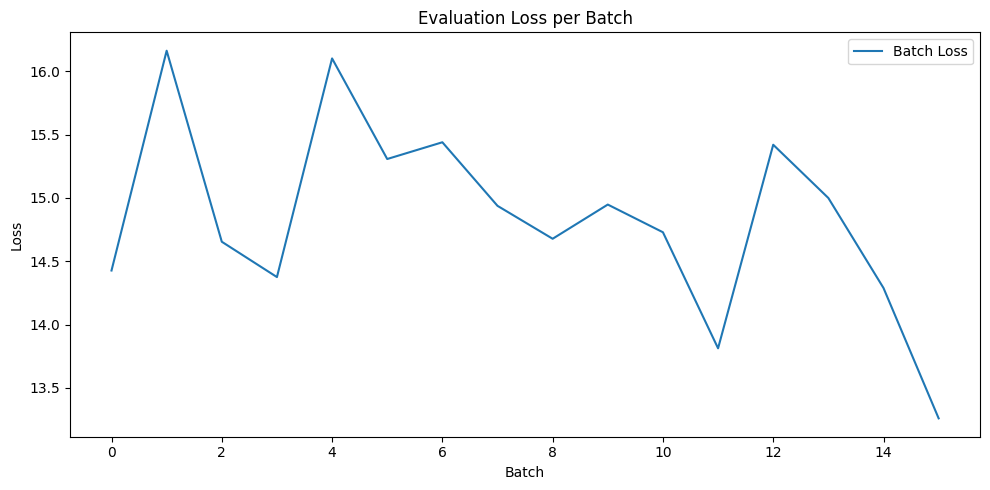

In [20]:
# Generate patch adversarial examples
patch_x_coords = []
patch_y_coords = []
patch_adv_images = []
patch_adv_labels = []
original_images = []

for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)

        # Get image dimensions
        _, _, h, w = img.shape

        # Random patch coordinates
        x = random.randint(0, w - 32)
        y = random.randint(0, h - 32)

        # Save coordinates and original image
        patch_x_coords.append(x)
        patch_y_coords.append(y)
        original_images.append(inputs[i].cpu())

        # Generate adversarial patch
        adv_img = patch_attack(img, label, pretrained_model,
                             epsilon=0.3, alpha=0.03, steps=10,
                             patch_size=32, x=x, y=y)

        patch_adv_images.append(adv_img.squeeze(0).cpu())
        patch_adv_labels.append(label.cpu())

# Create patch adversarial dataset
patch_adv_images_tensor = torch.cat([img.unsqueeze(0) for img in patch_adv_images])
patch_adv_labels_tensor = torch.cat(patch_adv_labels)
adv_dataset_3 = TensorDataset(patch_adv_images_tensor, patch_adv_labels_tensor)
torch.save(adv_dataset_3, "AdversarialTestSet3.pt")

# Evaluate patch attack
adv_loader_3 = DataLoader(adv_dataset_3, batch_size=32, shuffle=False)
patch_results = evaluate_model(pretrained_model, adv_loader_3, index_to_folder, folder_to_imagenet_id)
print(f"Patch Attack - Top-1 Accuracy: {patch_results['top1_accuracy']:.2f}%")
print(f"Patch Attack - Top-5 Accuracy: {patch_results['top5_accuracy']:.2f}%")

In [21]:
# Visualize patch attacks
def show_patch_attack(orig_img_tensor, adv_img_tensor, x, y, patch_size=32, title=None):
    """
    Visualize original and patch-attacked images with patch highlighted

    Args:
        orig_img_tensor: Original image tensor
        adv_img_tensor: Adversarial image tensor
        x, y: Patch coordinates
        patch_size: Size of patch
        title: Optional title for plot
    """
    orig_img = unnormalize(orig_img_tensor.detach()).permute(1, 2, 0).cpu().numpy()
    adv_img = unnormalize(adv_img_tensor.detach()).permute(1, 2, 0).cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(orig_img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(adv_img)
    axs[1].add_patch(plt.Rectangle((x, y), patch_size, patch_size,
                                edgecolor='red', facecolor='none', lw=2))
    axs[1].set_title("Adversarial (with patch)")
    axs[1].axis('off')

    if title:
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()

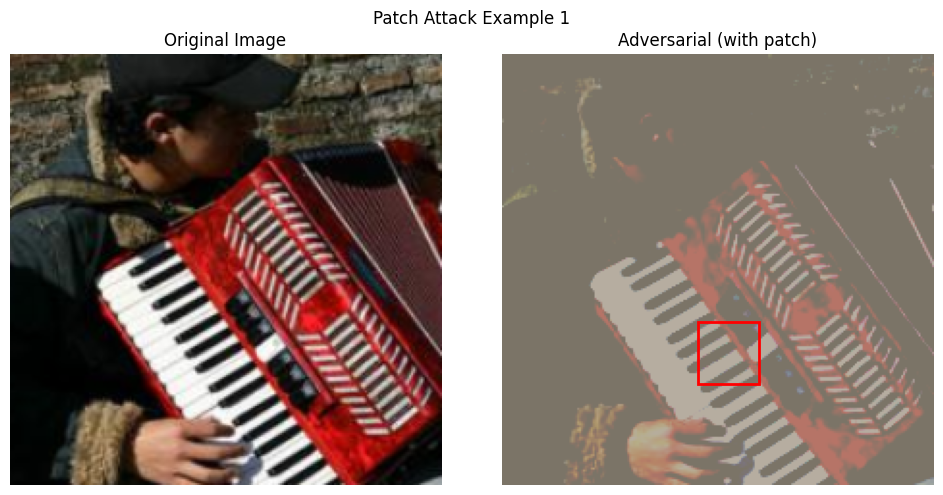

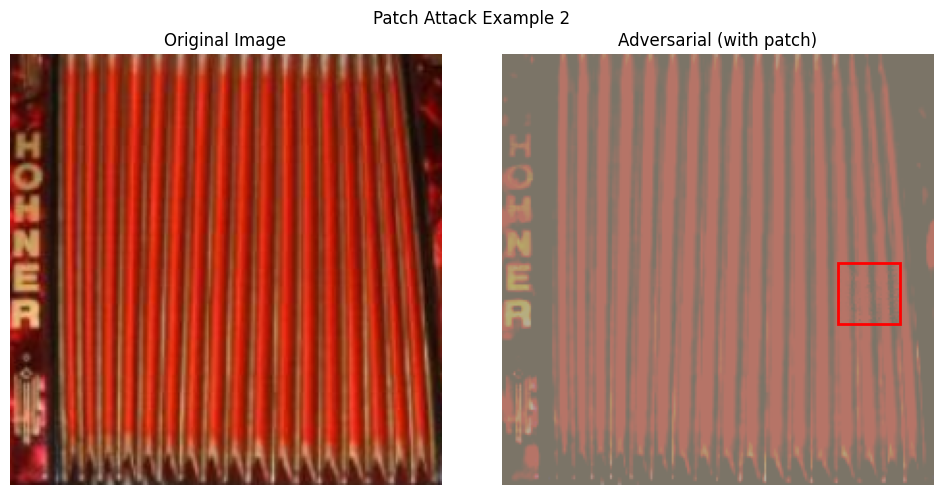

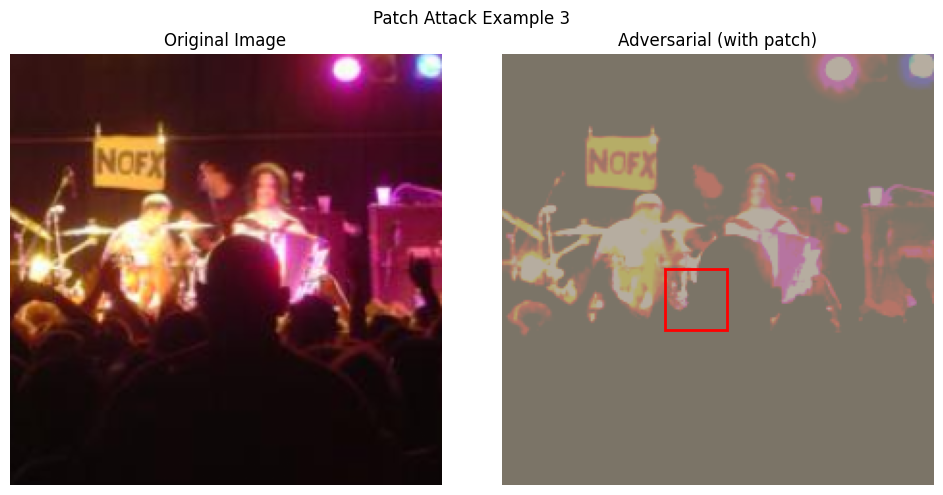

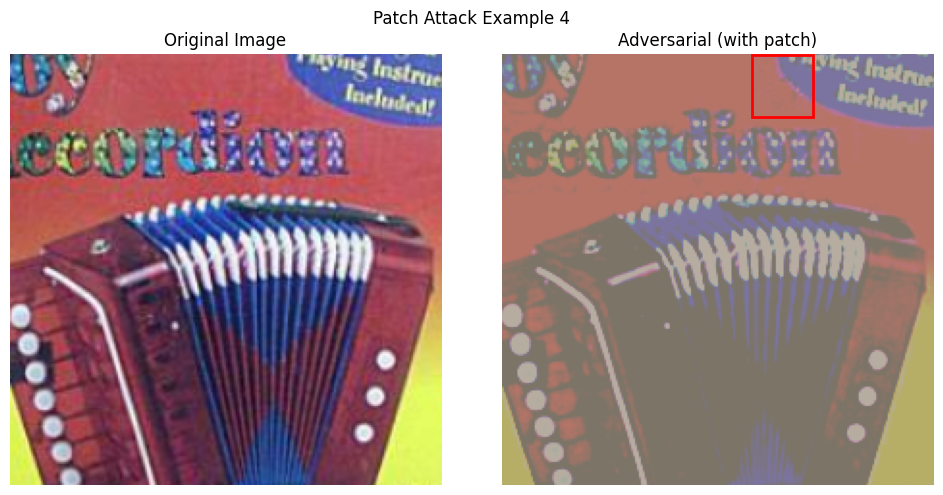

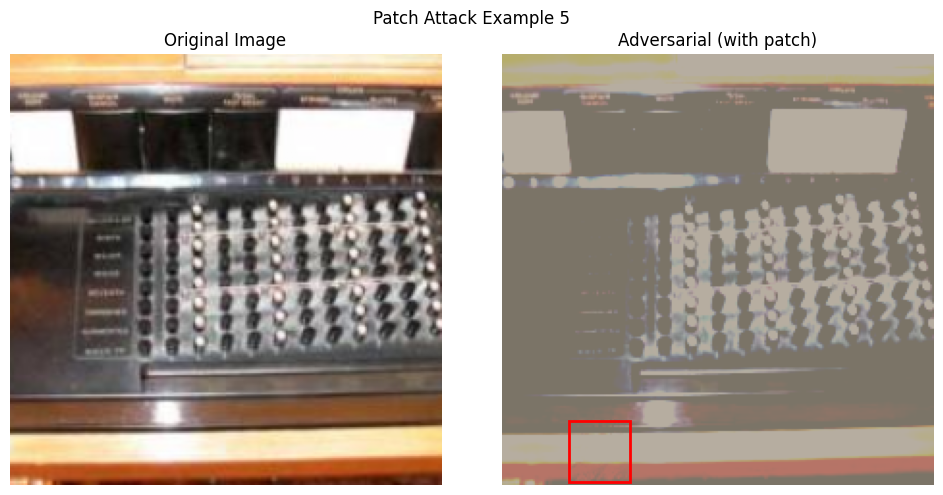

In [22]:
# Show examples of patch attacks
for i in range(num_examples):
    show_patch_attack(orig_img_tensor=original_images[i],
                     adv_img_tensor=patch_adv_images_tensor[i],
                     x=patch_x_coords[i],
                     y=patch_y_coords[i],
                     patch_size=32,
                     title=f"Patch Attack Example {i+1}")

In [23]:
# Task 5: Transferring Attacks
# ===========================

# Load DenseNet-121 model
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device)
new_model.eval()

# Define datasets to evaluate
datasets = {
    "Original": DataLoader(dataset, batch_size=32, shuffle=False),
    "Adversarial Set 1 (FGSM)": DataLoader(adv_dataset, batch_size=32, shuffle=False),
    "Adversarial Set 2 (Iterative)": DataLoader(adv_dataset_2, batch_size=32, shuffle=False),
    "Adversarial Set 3 (Patch)": DataLoader(adv_dataset_3, batch_size=32, shuffle=False)
}

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 110MB/s] 


Original - Top-1 Accuracy: 70.80%, Top-5 Accuracy: 91.20%
Adversarial Set 1 (FGSM) - Top-1 Accuracy: 41.00%, Top-5 Accuracy: 67.00%
Adversarial Set 2 (Iterative) - Top-1 Accuracy: 43.00%, Top-5 Accuracy: 65.60%
Adversarial Set 3 (Patch) - Top-1 Accuracy: 38.20%, Top-5 Accuracy: 65.20%


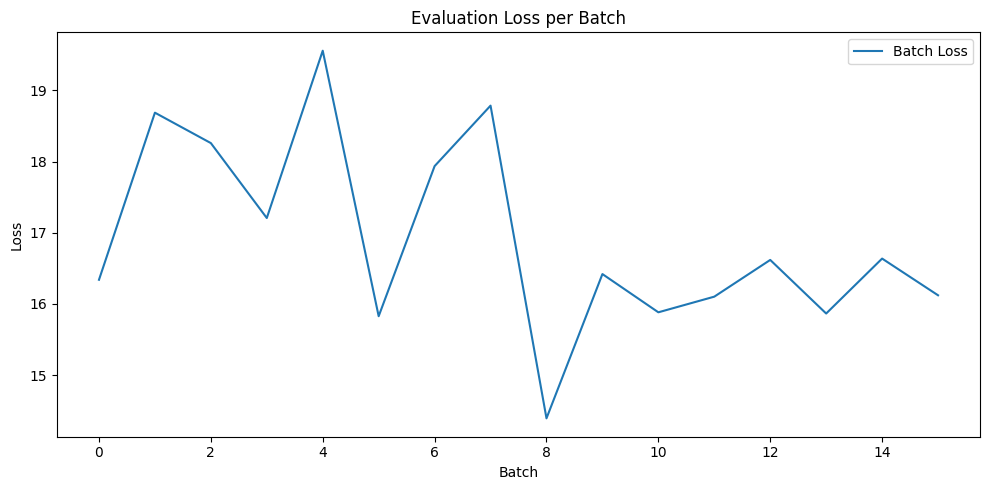

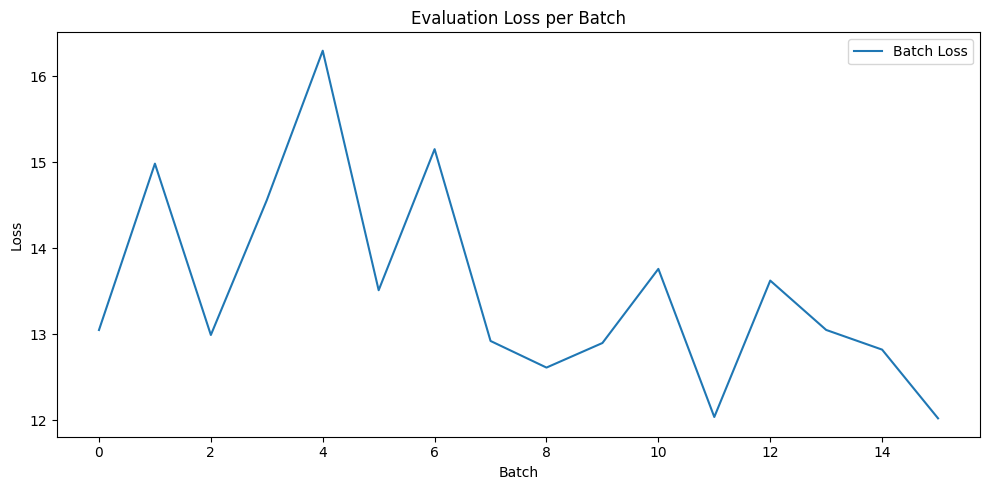

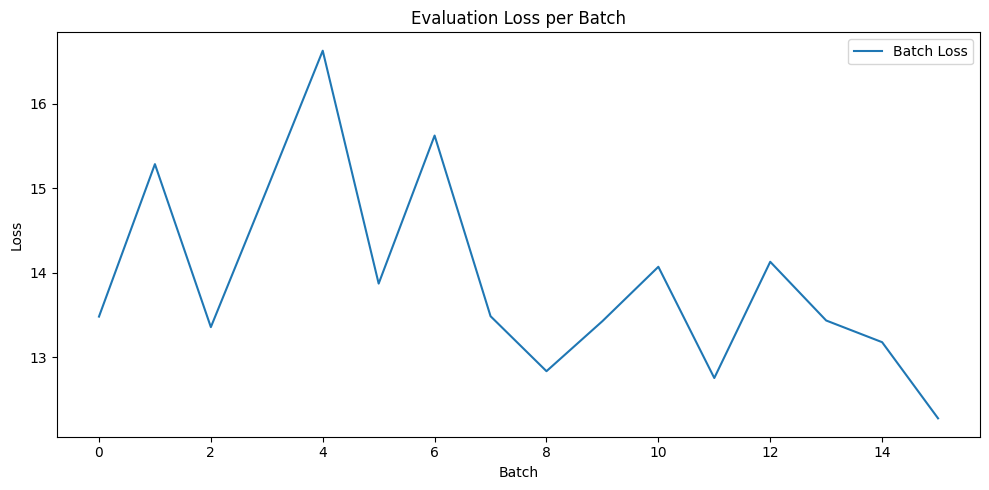

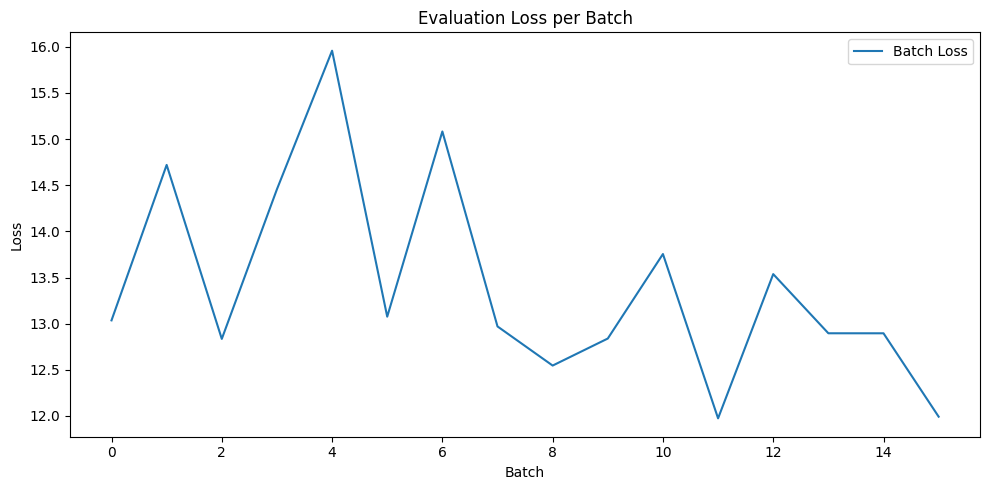

In [24]:
# Evaluate on DenseNet-121
transfer_results = {}
for name, loader in datasets.items():
    results = evaluate_model(new_model, loader, index_to_folder, folder_to_imagenet_id)
    transfer_results[name] = results
    print(f"{name} - Top-1 Accuracy: {results['top1_accuracy']:.2f}%, Top-5 Accuracy: {results['top5_accuracy']:.2f}%")

# Plot comparison of attack effectiveness
models = ['Original', 'FGSM', 'Iterative', 'Patch']
top1_scores = [base_results['top1_accuracy'],
               fgsm_results['top1_accuracy'],
               iterative_results['top1_accuracy'],
               patch_results['top1_accuracy']]
top5_scores = [base_results['top5_accuracy'],
               fgsm_results['top5_accuracy'],
               iterative_results['top5_accuracy'],
               patch_results['top5_accuracy']]

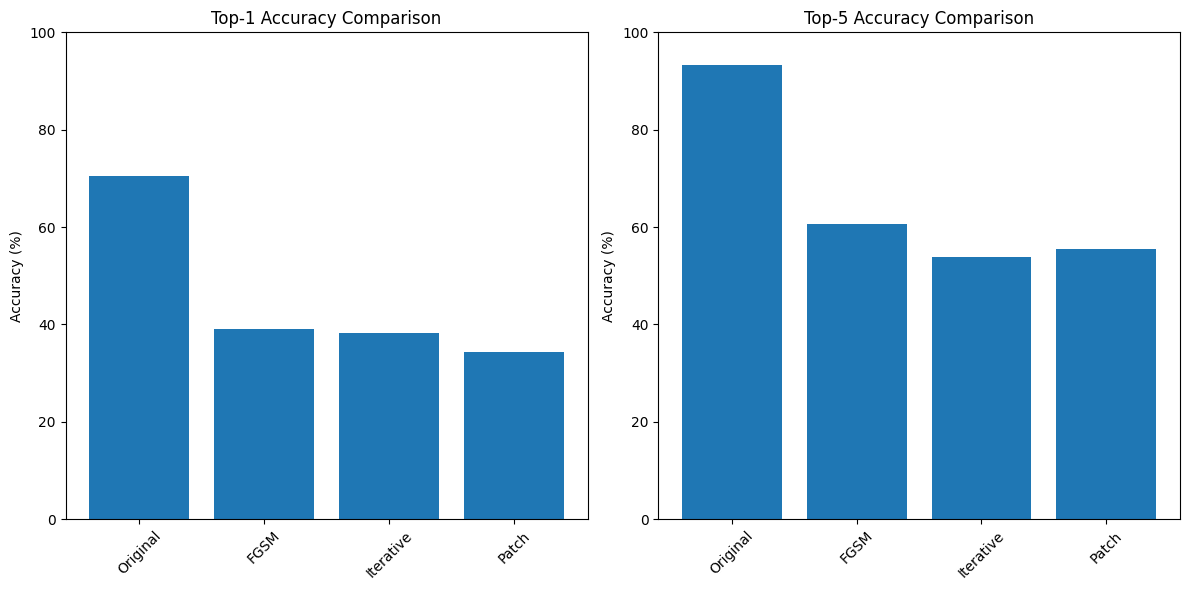

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(models, top1_scores)
plt.title('Top-1 Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(models, top5_scores)
plt.title('Top-5 Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


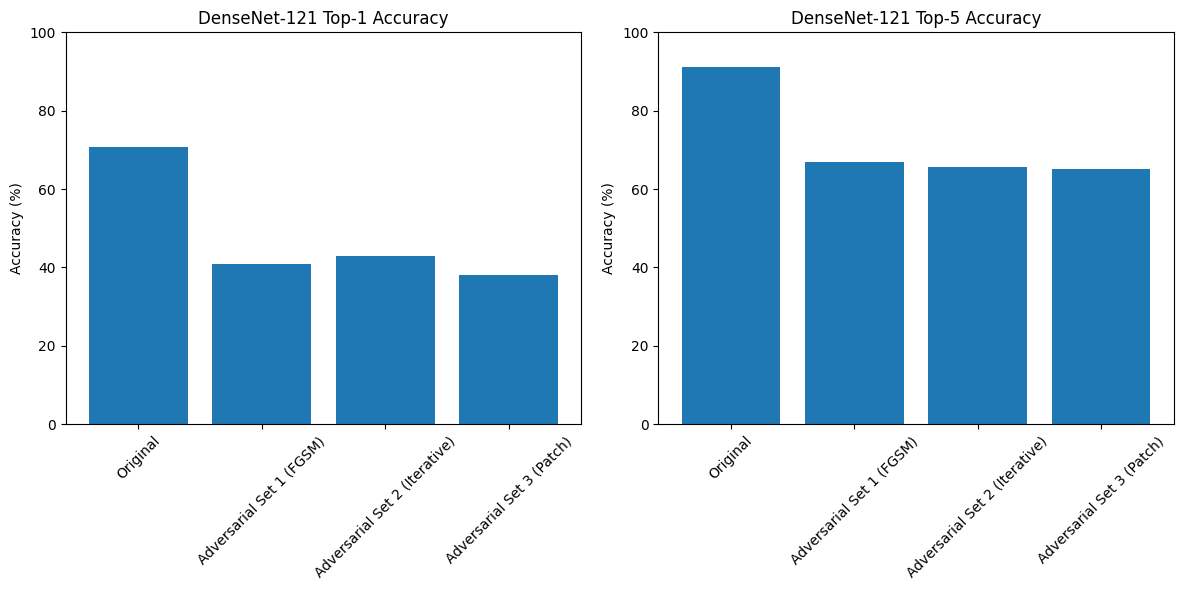

In [26]:
# Plot transferability results
transfer_top1 = [transfer_results[name]['top1_accuracy'] for name in datasets]
transfer_top5 = [transfer_results[name]['top5_accuracy'] for name in datasets]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(datasets.keys(), transfer_top1)
plt.title('DenseNet-121 Top-1 Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(datasets.keys(), transfer_top5)
plt.title('DenseNet-121 Top-5 Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()